<a href="https://colab.research.google.com/github/ZDDATApol4/prediction-political-preferences/blob/main/notebooks/Final_GUI_projekt_ko%C5%84cowy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
#@title <----- Najpierw uruchom to

%%capture
!git clone https://github.com/ZDDATApol4/prediction-political-preferences/

!pip install spacy==3
!python -m spacy download pl_core_news_sm
!pip install stop_words

import tweepy
import pandas as pd
import time
import keras
import spacy
import numpy as np
import seaborn as sns
import string
from string import digits
import re
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import load_model
from plotly.offline import iplot
import matplotlib.pyplot as plt
%matplotlib inline

from stop_words import get_stop_words
from tensorflow.keras.utils import to_categorical


# Twitter_Credentials

consumer_key = "5MzB6K9I3B0hVF0BOs2UjybSz"
consumer_secret = "hiPjP10G7bTuomHflC1vCWzwcdsAB444WkE0MkSZwGGfALoxBS"
access_token = "1437020925040513029-s6Dqtv9lPyufnlKtzm9tF3BQEQ8FCA"
access_token_secret = "D9SUsW12b1ya9LuWPNNmGmU0NhKIJzoeFfHsIy4xgdJ7x"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

tweets = []

def username_tweets_to_csv(username,count):
    try:      
        # Creation of query method using parameters
        tweets = tweepy.Cursor(api.user_timeline,id=username).items(count)

        # Pulling information from tweets iterable object
        tweets_list = [[tweet.user.screen_name, tweet.created_at, tweet.id, tweet.text] for tweet in tweets]

        # Creation of dataframe from tweets list
        tweets_df = pd.DataFrame(tweets_list,columns=['Author', 'Datetime', 'Tweet Id', 'Text'])
                      
        return tweets_df

    except BaseException as e:
          print('failed on_status,',str(e))
          time.sleep(3)

def lemmatize_text(text_corpus):
  lemmatized_text = []
  for tweet in tqdm(text_corpus):
    doc = nlp(tweet)
    doc_lemmatized = []
    for x in doc:
      if x.is_punct == False and x.is_stop == False:
        doc_lemmatized.append(x.lemma_)
    lemmatized_text.append(doc_lemmatized)
  return lemmatized_text

def tokenize(num_words, lemmatized_text, maxlen):
  tokenizer = Tokenizer(num_words=num_words)
  tokenizer.fit_on_texts(lemmatized_text)
  sequences = tokenizer.texts_to_sequences(lemmatized_text)
  padded = pad_sequences(sequences, maxlen=maxlen)
  print(padded.shape)
  return padded

nlp = spacy.load('pl_core_news_sm')

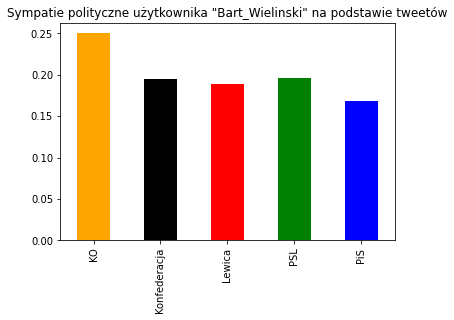

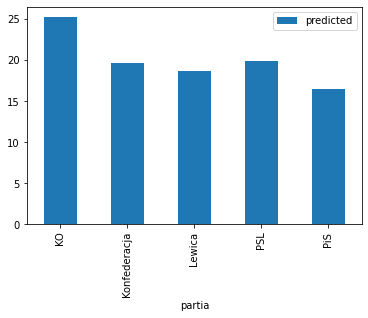

In [72]:
#@title Wpisz Twitter ID i naciśnij PLAY

ID = "Bart_Wielinski" #@param ["", ""] {allow-input: true}

count = 1000
data = username_tweets_to_csv(ID, count)


#Data processing

data = data[data['Datetime'] >= pd.to_datetime('2021-08-01')]
test_text_corpus = data['Text']
data = data.astype({'Datetime' : 'datetime64'})
stop_words = list(get_stop_words("pl"))
df_m = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stop_words)


def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
def clean_text2(text):
    regex = r'https?:\/\/.*[\r\n]*'
    text = re.sub(regex, '', text, flags=re.MULTILINE)
    text = re.sub(regex, '', text, flags=re.MULTILINE)
    # Remove quotes from source and target text
    text = re.sub("'", '', text)
    text = re.sub("'", '', text)
    # create a set of all special characters
    special_characters= set(string.punctuation)
    # Remove all the special characters
    text = ''.join(char1 for char1 in text if char1 not in special_characters)
    text = ''.join(char1 for char1 in text if char1 not in special_characters)
    # Remove digits from source and target sentences
    num_digits= str.maketrans('','', digits)
    text = text.translate(num_digits)
    text = text.translate(num_digits)
    text = re.sub(r'[\r\n]', '', text, flags=re.MULTILINE)
    text = re.sub(r'[\r\n]', '', text, flags=re.MULTILINE)
    text = re.sub(r'\s{2,}', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\s{2,}', ' ', text, flags=re.MULTILINE)
    return text
    
df_m['Text'] = df_m['Text'].apply(clean_text)
df_m['Text'] = df_m['Text'].apply(clean_text2)
df_m['Text'] = df_m['Text'].str.replace('\d+', '')
df_m = df_m[df_m.Text.str.len() > 19]
df_m_train = df_m[df_m['Datetime'] < pd.to_datetime('2021-08-01')]
df_m_test = df_m[df_m['Datetime'] >= pd.to_datetime('2021-08-01')]

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_m['Text'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df_m['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

X_train = tokenizer.texts_to_sequences(df_m_train['Text'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(df_m_test['Text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

#loaded_model = load_model('prediction-political-preferences/models/best_model5.hdf5')
loaded_model = load_model('prediction-political-preferences/models/model_3z.h5')
predicted = loaded_model.predict(X_test)

df = pd.DataFrame(predicted, columns=['KO', 'Konfederacja', 'Lewica', 'PSL', 'PiS'])

#Wykres ze średnią
df.mean().plot.bar(color=['orange', 'black', 'red', 'green', 'blue'])
plt.title(f'Sympatie polityczne użytkownika "{ID}" na podstawie tweetów')
plt.show()

#Wykres z max dla każdego tweeta
prediction_tweets = df.copy()
prediction_tweets['partia'] = prediction_tweets.idxmax(axis=1)
prediction_tweets['predicted'] = prediction_tweets.max(axis=1)
prediction_tweets.groupby('partia')[['predicted']].count().apply(lambda x: x/float(x.sum())).mul(100).plot.bar()

